In [27]:
pip install atacnet -I

  Using cached atacnet-0.1.0-cp311-cp311-manylinux_2_35_x86_64.whl
  Using cached joblib-1.3.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached numpy-1.26.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached pandas-2.1.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (18 kB)
  Using cached scanpy-1.9.6-py3-none-any.whl.metadata (6.0 kB)
  Using cached scikit_learn-1.3.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached tqdm-4.66.1-py3-none-any.whl.metadata (57 kB)
  Using cached python_dateutil-2.8.2-py2.py3-none-any.whl (247 kB)
  Using cached pytz-2023.3.post1-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2023.4-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached anndata-0.10.4-py3-none-any.whl.metadata (6.4 kB)
  Using cached h5py-3.10.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.5 kB)
  Using cached matplotlib-3.8.2-cp311-cp311-manylinux

In [126]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, message=r".*Reordering categories will always return a new Categorical object.*")
warnings.filterwarnings("ignore", category=FutureWarning, message=r".*is_categorical_dtype is deprecated and will be removed in a future version.*")

In [127]:
import atacnet as an
import atacnet.metacells
import scanpy as sc

In [128]:
?an.add_region_infos

Signature: an.add_region_infos(AnnData, sep=('_', '_'), inplace=True)
Docstring:
Get region informations from the var_names of AnnData object.
e.g. chr1_12345_12346 -> 'chromosome' : chr1,
                         'start' : 12345,
                         'end' : 12346
These info will be added to var of AnnData object.
    adata.var['chromosome'] : chromosome
    adata.var['start'] : start position
    adata.var['end'] : end position

Parameters
----------
AnnData : AnnData object
    AnnData object with var_names as region names.
sep : tuple, optional
    Separator of region names. The default is ('_', '_').

Returns
-------
AnnData : AnnData object
    AnnData object with region informations in var.
File:      ~/miniconda3/envs/t3/lib/python3.11/site-packages/atacnet/atacnet.py
Type:      function

In [129]:
import numpy as np
import pandas as pd
import anndata as ad

import scipy as sp
from scipy import linalg
from sklearn.datasets import make_sparse_spd_matrix
import matplotlib.pyplot as plt

# Test with sparse covariance true matrix as GT

### 0. Create fake AnnData

In [130]:
# Create fake single-cell atac-seq data
nb_cells = 300
nb_chr = 10
nb_regions_per_chr = 200
between_reg = 2000
size_reg = 50

counts = []
for chr in range(nb_chr):
    counts.append(pd.DataFrame(np.random.randint(0,100, size=(nb_cells, nb_regions_per_chr)),
                        index=['Cell_'+j for j in map(str, range(nb_cells))],
                        columns=['chr'+str(chr)+'_'+str(i)+'_'+str(i+size_reg) for i in range(1, nb_regions_per_chr*between_reg+1, between_reg)]))
atac = ad.AnnData(pd.concat(counts, axis=1))

In [131]:
distance_threshold = 50000

### 1. Add region position in AnnData.obs

In [132]:
an.add_region_infos(atac)

### 2. Replace random data with fake cov matrix

In [133]:
n_samples, n_features = 300, nb_regions_per_chr

prng = np.random.RandomState(0)
prec = make_sparse_spd_matrix(
    n_features, alpha=0.98, smallest_coef=0.4, largest_coef=0.7, random_state=prng
)
cov = linalg.inv(prec)

#cov with only potential connections
possible_co = sp.sparse.csr_matrix(an.atacnet.get_distances_regions(atac)<distance_threshold/2)[:cov.shape[0],:cov.shape[1]]
possible_co = sp.sparse.coo_matrix(possible_co).toarray() + sp.sparse.coo_matrix(possible_co).toarray().T 
cov = np.eye(len(cov))*np.diag(cov) + possible_co*cov 
d = np.sqrt(np.diag(cov))
cov /= d
cov /= d[:, np.newaxis]
prec *= d
prec *= d[:, np.newaxis]
X = prng.multivariate_normal(np.zeros(n_features), cov, size=n_samples)
X -= X.mean(axis=0)
X /= X.std(axis=0)

X_ = np.concatenate([X]*nb_chr, axis=1)
atac.X = np.abs(X_)
atac.X = np.where(X_<0, 0, X_)

### 2.A. Remove Null rows

In [134]:
sc.pp.filter_genes(atac, min_cells=1)
atac

AnnData object with n_obs × n_vars = 300 × 2000
    var: 'chromosome', 'start', 'end', 'n_cells'

### 2.B. Compute pseudocells

In [135]:
metacells = an.metacells.compute_metacells(atac)
an.add_region_infos(metacells)

Output()

### 3 Calculate co-accessibility

In [136]:
an.compute_atac_network(
    metacells,
    window_size=distance_threshold,
    unit_distance = 1000,
    distance_constraint=distance_threshold/2,
    n_samples=50,
    n_samples_maxtry=100,
    max_alpha_iteration=60
)

Output()

Output()

Starting to process chromosomes : ['chr0' 'chr1' 'chr2' 'chr3' 'chr4' 'chr5' 'chr6' 'chr7' 'chr8' 'chr9']


Output()

Finishing to process chromosomes : ['chr0' 'chr1' 'chr2' 'chr3' 'chr4' 'chr5' 'chr6' 'chr7' 'chr8' 'chr9']


Averaging co-accessibility scores across windows...
Done !


*Can be stored externally using sliding_graphica_lasso*

In [137]:
atac.X = sp.sparse.csr_matrix(atac.X)
# atac.X = atac.X.toarray()

In [138]:
an.atacnet.average_alpha(
    atac,
    window_size=distance_threshold,
    unit_distance = 1000,
    distance_constraint=distance_threshold/2,
    n_samples=50,
    n_samples_maxtry=100,
    max_alpha_iteration=60)

Output()

0.04206783287587425

In [139]:
final_score = an.sliding_graphical_lasso(
    atac,
    window_size=distance_threshold,
    unit_distance = 1000,
    distance_constraint=distance_threshold/2,
    n_samples=50,
    n_samples_maxtry=100,
    max_alpha_iteration=60
)
atac.varp['atac_network'] = final_score

Output()

Output()

Starting to process chromosomes : ['chr0' 'chr1' 'chr2' 'chr3' 'chr4' 'chr5' 'chr6' 'chr7' 'chr8' 'chr9']


Output()

Finishing to process chromosomes : ['chr0' 'chr1' 'chr2' 'chr3' 'chr4' 'chr5' 'chr6' 'chr7' 'chr8' 'chr9']


Averaging co-accessibility scores across windows...
Done !


### 3. B. Extract list of edges

In [168]:
an.extract_atac_links(metacells)

,Peak1,Peak2,score
4274,chr2_74001_74051,chr2_82001_82051,0.016845
15842,chr8_74001_74051,chr8_82001_82051,0.016845
10058,chr5_74001_74051,chr5_82001_82051,0.016845
13914,chr7_74001_74051,chr7_82001_82051,0.016845
2346,chr1_74001_74051,chr1_82001_82051,0.016845
...,...,...,...
11291,chr5_334001_334051,chr5_356001_356051,-0.010226
17075,chr8_334001_334051,chr8_356001_356051,-0.010226
7435,chr3_334001_334051,chr3_356001_356051,-0.010226
19003,chr9_334001_334051,chr9_356001_356051,-0.010226


In [169]:
an.extract_atac_links(atac).set_index(['Peak1', 'Peak2'])

,,score
Peak1,Peak2,
chr7_1_51,chr7_14001_14051,0.083969
chr9_1_51,chr9_14001_14051,0.083969
chr3_1_51,chr3_14001_14051,0.083969
chr8_1_51,chr8_14001_14051,0.083969
chr1_1_51,chr1_14001_14051,0.083969
...,...,...
chr5_88001_88051,chr5_90001_90051,-0.027294
chr0_88001_88051,chr0_90001_90051,-0.027294
chr9_88001_88051,chr9_90001_90051,-0.027294


### 4. Plot comparison between co-accessibility scores and covariance matrix used to generate the data

0.475 0.58


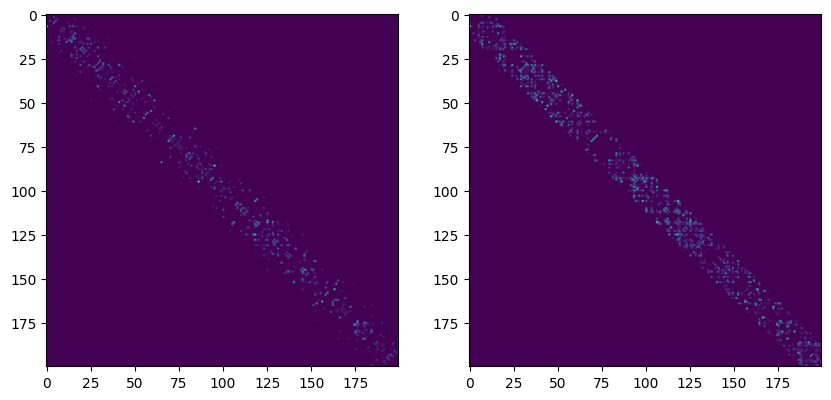

In [148]:
def diag_block_mat_slicing(L):
    shp = L[0].shape
    N = len(L)
    r = range(N)
    out = np.zeros((N,shp[0],N,shp[1]),dtype=int)
    out[r,:,r,:] = L
    return out.reshape(np.asarray(shp)*N)

corrected = final_score.toarray()[:200, :200]
corrected = np.where(corrected <= 0, corrected, corrected)
corrected = corrected - np.diag(corrected)*np.eye(len(cov))

cov_ = cov - np.diag(cov)*np.eye(len(cov))

fig, ax = plt.subplots(1, 2, figsize=(10,10))
ax[0].imshow(np.abs(corrected))
ax[1].imshow(np.where(cov_<=0, cov_, cov_))


print((corrected[:20,:20]>0).sum()/(400), (cov_[:20,:20]>0).sum()/(400),)

0.01 0.8


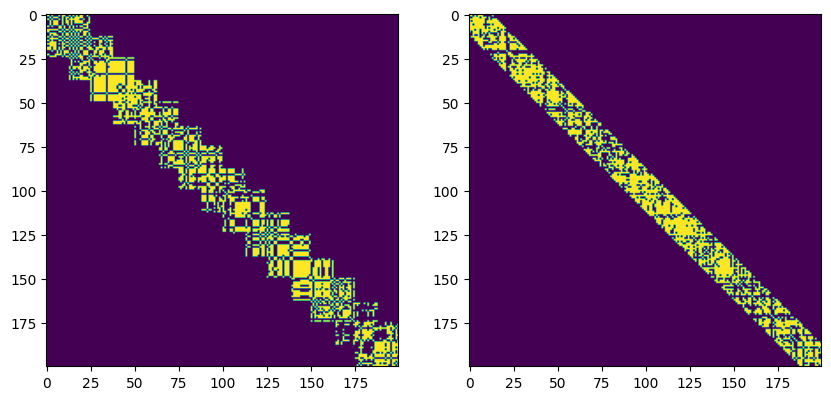

In [162]:
corrected = final_score.toarray()[:200, :200]
corrected = np.where(corrected <= 0, 0, 1)


fig, ax = plt.subplots(1, 2, figsize=(10,10))
ax[0].imshow(corrected)
ax[1].imshow(np.where(cov<=0, 0, 1))

print((corrected[10,10]>0).sum()/(100), (cov[:10,:10]>0).sum()/(100))

In [163]:
df = pd.DataFrame([cov.flatten(), corrected.flatten()]).transpose()